In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score
from scipy.stats import kendalltau, chi2_contingency

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
FICHEIRO_COMITE_LLM = '../../data/judged/committee_llm_consensus.csv'
FICHEIRO_GROUND_TRUTH_HUMANO = '../../data/judged/human_ground_truth.csv'
NIVEL_DE_CONFIANCA = 0.95

### Parâmetros dos Juízes-LLM ###

In [4]:
config_juizes = pd.DataFrame({
    'Juiz': ['Claude', 'Prometheus', 'Mistral'],
    'Modelo': [
        'claude-sonnet-4-20250514',
        'kaist-ai/Prometheus-13b-v1.0 (via Llama-2-7b-chat-hf tokenizer)',
        'mistralai/Mistral-7B-Instruct-v0.3'
    ],
    'Temperatura': [0.0, 0.0, 0.0],
    'Top-P': ['N/A (temp=0)', 'N/A (do_sample=False)', 'N/A (temp=0)'],
    'Max Tokens': [1024, 500, 1024],
    'Seed Explícito': ['Não', 'Não', 'Não']
})

In [5]:
print("--- Parâmetros dos Juízes-LLM ---\n")
print(config_juizes.to_string(index=False))

--- Parâmetros dos Juízes-LLM ---

      Juiz                                                          Modelo  Temperatura                 Top-P  Max Tokens Seed Explícito
    Claude                                        claude-sonnet-4-20250514          0.0          N/A (temp=0)        1024            Não
Prometheus kaist-ai/Prometheus-13b-v1.0 (via Llama-2-7b-chat-hf tokenizer)          0.0 N/A (do_sample=False)         500            Não
   Mistral                              mistralai/Mistral-7B-Instruct-v0.3          0.0          N/A (temp=0)        1024            Não


#### Controle de Aleatoriedade ###

1. Seed de Embaralhamento:
   - random_state=42 aplicado ao shuffle inicial dos pares
   - Garante ordem reprodutível de avaliação

2. Determinismo dos Juízes:
   - Temperature=0 ou do_sample=False → greedy decoding
   - Sem seed explícito via API (não disponível na maioria)
   - Na prática: respostas altamente determinísticas

3. Origem do sample_n (1-5):
   - Representa 5 PARES DIFERENTES da mesma configuração
   - Exemplo: TC014_gemini_1 é uma pergunta diferente de TC014_gemini_2
   - Não são re-runs com seeds diferentes
   - Variância entre sample_n mede instabilidade ENTRE casos similares

#### Estratégia de Amostragem ###

- Total de pares avaliados: 1500
- Execuções por configuração (sample_n): 5 (seeds implícitos nos IDs)
- O sample_n (1-5) representa diferentes execuções da mesma configuração
- Shuffle: random_state=42 antes da avaliação
- Validação humana: 150 pares (10% do total)
- Formato do evaluation_id: 
  <question_id>_<model>_<sample_n>_<domain>_<comparison>_<language>
  
  Exemplo:

         TC014_gemini-1.5-pro-latest_1_Technical_contextual_vs_minimum_en_vs_pt
           ↑                         ↑                                         
           Pergunta base             1ª de 5 variações                         

#### Nota sobre Heterogeneidade de Parâmetros ###

Prometheus foi executado com max_tokens=500 (vs 1024 nos demais) devido a:
1. Limitações de memória GPU no offload
2. Análise prévia mostrou que 500 tokens são suficientes para o formato JSON

Esta heterogeneidade é aceitável porque:
1. Cada juiz mantém consistência interna (mesmo parâmetro para todos os casos)
2. O comitê usa voto por maioria (diluição de efeitos individuais)
3. Validação vs humanos mostrou concordância estatisticamente significativa

### CARREGAMENTO E PREPARAÇÃO DOS DADOS

In [6]:
df_llm = pd.read_csv(FICHEIRO_COMITE_LLM)
df_llm.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A


In [7]:
df_human = pd.read_csv(FICHEIRO_GROUND_TRUTH_HUMANO)
df_human.head(2)

,evaluation_id,human_winner
0,CG001_sabia-3.1_2_General Knowledge_detailed_e...,Tie
1,CG002_1_General Knowledge_minimum_gemini-1.5-p...,B


In [8]:
df_analise = pd.merge(df_llm, df_human, on='evaluation_id', how='left')
print("\nFicheiros juntados com sucesso.")
df_analise.shape


Ficheiros juntados com sucesso.


(1500, 14)

In [9]:
df_validacao = df_analise[df_analise['human_winner'].notna()].copy()
df_validacao.shape

(150, 14)

In [10]:
def extrair_metadados(evaluation_id):
    if not isinstance(evaluation_id, str):
        return None, None, None
    
    # Extrair sample_n (número antes do último '_')
    parts = evaluation_id.split('_')
    sample_n = None
    for i, part in enumerate(parts):
        if part.isdigit():
            sample_n = int(part)
            break
    
    # Extrair domínio
    domains = ['Technical', 'General Knowledge', 'Creative']
    domain = next((d for d in domains if d in evaluation_id), 'Desconhecido')
    
    # Extrair língua
    if evaluation_id.endswith('_en_vs_pt'):
        lang = 'EN vs PT'
    elif evaluation_id.endswith('_en'):
        lang = 'EN'
    elif evaluation_id.endswith('_pt'):
        lang = 'PT'
    
    return domain, lang, sample_n

In [11]:
df_analise[['domain', 'language_context', 'sample_n']] = df_analise['evaluation_id'].apply(
    lambda x: pd.Series(extrair_metadados(x))
)
df_validacao[['domain', 'language_context', 'sample_n']] = df_validacao['evaluation_id'].apply(
    lambda x: pd.Series(extrair_metadados(x))
)

In [12]:
df_analise.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A,A,Technical,EN vs PT,1
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A,B,General Knowledge,EN vs PT,4


### CONCORDÂNCIA INTERNA DO COMITÊ

In [13]:
def proporcao_com_ic(n_sucessos, n_total, nivel_confianca=0.95):
    """
    Calcula proporção com intervalo de confiança usando método de Wilson
    Mais robusto que o método normal, especialmente para proporções próximas de 0 ou 1
    """
    if n_total == 0:
        return 0, 0, 0
    
    z = stats.norm.ppf((1 + nivel_confianca) / 2)
    p = n_sucessos / n_total
    
    denominador = 1 + z**2/n_total
    centro = (p + z**2/(2*n_total)) / denominador
    margem = z * np.sqrt((p*(1-p)/n_total + z**2/(4*n_total**2))) / denominador
    
    return p, max(0, centro - margem), min(1, centro + margem)

In [14]:
def formatar_ic(prop, ic_inf, ic_sup):
    """Formata proporção com IC para impressão"""
    return f"{prop:.2%} (IC 95%: [{ic_inf:.2%}, {ic_sup:.2%}])"

In [15]:
df_validacao = df_analise[df_analise['human_winner'].notna()].copy()
print(f"A analisar a concordância do comitê em {len(df_validacao)} pares.")

A analisar a concordância do comitê em 150 pares.


In [16]:
judges = ['claude', 'prometheus', 'mistral']

In [17]:
def get_agreement_type(row):
    votes = [row.get(f'{j}_winner') for j in judges]
    valid_votes = [v for v in votes if pd.notna(v)]
    if len(valid_votes) < 3: return "Dados em Falta"
    unique_votes = len(set(valid_votes))
    if unique_votes == 1: return 'Unânime (3-0)'
    elif unique_votes == 2: return 'Maioria (2-1)'
    else: return 'Discordância Total (1-1-1)'

In [18]:
df_validacao['tipo_concordancia'] = df_validacao.apply(get_agreement_type, axis=1)
df_validacao.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n,tipo_concordancia
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A,A,Technical,EN vs PT,1,Unânime (3-0)
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A,B,General Knowledge,EN vs PT,4,Maioria (2-1)


In [19]:
print("\n--- Distribuição Global de Consenso ---\n")
for tipo in ['Unânime (3-0)', 'Maioria (2-1)', 'Discordância Total (1-1-1)']:
    n = (df_validacao['tipo_concordancia'] == tipo).sum()
    prop, ic_inf, ic_sup = proporcao_com_ic(n, len(df_validacao))
    print(f"{tipo:30s}: {formatar_ic(prop, ic_inf, ic_sup)}")


--- Distribuição Global de Consenso ---

Unânime (3-0)                 : 22.67% (IC 95%: [16.70%, 30.00%])
Maioria (2-1)                 : 63.33% (IC 95%: [55.38%, 70.62%])
Discordância Total (1-1-1)    : 14.00% (IC 95%: [9.34%, 20.46%])


In [20]:
print("\n--- Consenso por Domínio ---\n")
consenso_por_dominio = df_validacao.groupby('domain')['tipo_concordancia'].value_counts(normalize=True).unstack(fill_value=0)

for domain in consenso_por_dominio.index:
    print(f"\n{domain}:")
    for tipo in consenso_por_dominio.columns:
        n_total = (df_validacao['domain'] == domain).sum()
        n = (df_validacao[df_validacao['domain'] == domain]['tipo_concordancia'] == tipo).sum()
        prop, ic_inf, ic_sup = proporcao_com_ic(n, n_total)
        print(f"  {tipo:30s}: {formatar_ic(prop, ic_inf, ic_sup)}")


--- Consenso por Domínio ---


Creative:
  Discordância Total (1-1-1)    : 12.24% (IC 95%: [5.73%, 24.24%])
  Maioria (2-1)                 : 75.51% (IC 95%: [61.91%, 85.40%])
  Unânime (3-0)                 : 12.24% (IC 95%: [5.73%, 24.24%])

General Knowledge:
  Discordância Total (1-1-1)    : 12.96% (IC 95%: [6.42%, 24.42%])
  Maioria (2-1)                 : 66.67% (IC 95%: [53.36%, 77.76%])
  Unânime (3-0)                 : 20.37% (IC 95%: [11.77%, 32.90%])

Technical:
  Discordância Total (1-1-1)    : 17.02% (IC 95%: [8.89%, 30.14%])
  Maioria (2-1)                 : 46.81% (IC 95%: [33.33%, 60.77%])
  Unânime (3-0)                 : 36.17% (IC 95%: [23.97%, 50.46%])


* **Discordância por Domínio**: Os juízes tiveram mais dificuldade em concordar sobre as respostas no domínio Técnico (onde a discordância total foi de 17.02%). Pode significar que as respostas técnicas eram ou muito parecidas em qualidade, tornando a escolha subjetiva, ou que os juízes têm opiniões diferentes sobre o que constitui uma boa resposta técnica.

In [21]:
print("\n--- Consenso por Contexto de Língua ---\n")
consenso_por_lingua = df_validacao.groupby('language_context')['tipo_concordancia'].value_counts(normalize=True).unstack(fill_value=0)

for lang in consenso_por_lingua.index:
    print(f"\n{lang}:")
    for tipo in consenso_por_lingua.columns:
        n_total = (df_validacao['language_context'] == lang).sum()
        n = (df_validacao[df_validacao['language_context'] == lang]['tipo_concordancia'] == tipo).sum()
        prop, ic_inf, ic_sup = proporcao_com_ic(n, n_total)
        print(f"  {tipo:30s}: {formatar_ic(prop, ic_inf, ic_sup)}")



--- Consenso por Contexto de Língua ---


EN:
  Discordância Total (1-1-1)    : 14.81% (IC 95%: [7.70%, 26.60%])
  Maioria (2-1)                 : 62.96% (IC 95%: [49.63%, 74.58%])
  Unânime (3-0)                 : 22.22% (IC 95%: [13.20%, 34.94%])

EN vs PT:
  Discordância Total (1-1-1)    : 5.88% (IC 95%: [2.02%, 15.92%])
  Maioria (2-1)                 : 72.55% (IC 95%: [59.05%, 82.89%])
  Unânime (3-0)                 : 21.57% (IC 95%: [12.49%, 34.63%])

PT:
  Discordância Total (1-1-1)    : 22.22% (IC 95%: [12.54%, 36.27%])
  Maioria (2-1)                 : 53.33% (IC 95%: [39.08%, 67.06%])
  Unânime (3-0)                 : 24.44% (IC 95%: [14.24%, 38.67%])


* **Discordância por Língua**: Os juízes discordaram mais ao avaliar as respostas apenas em Português (PT), com 22.22% de discordância total. Em contraste, eles concordaram mais quando comparavam uma resposta em Inglês com uma resposta traduzida (EN vs PT). Isto sugere que as nuances do português podem ser mais difíceis de avaliar de forma consistente pelo comitê.

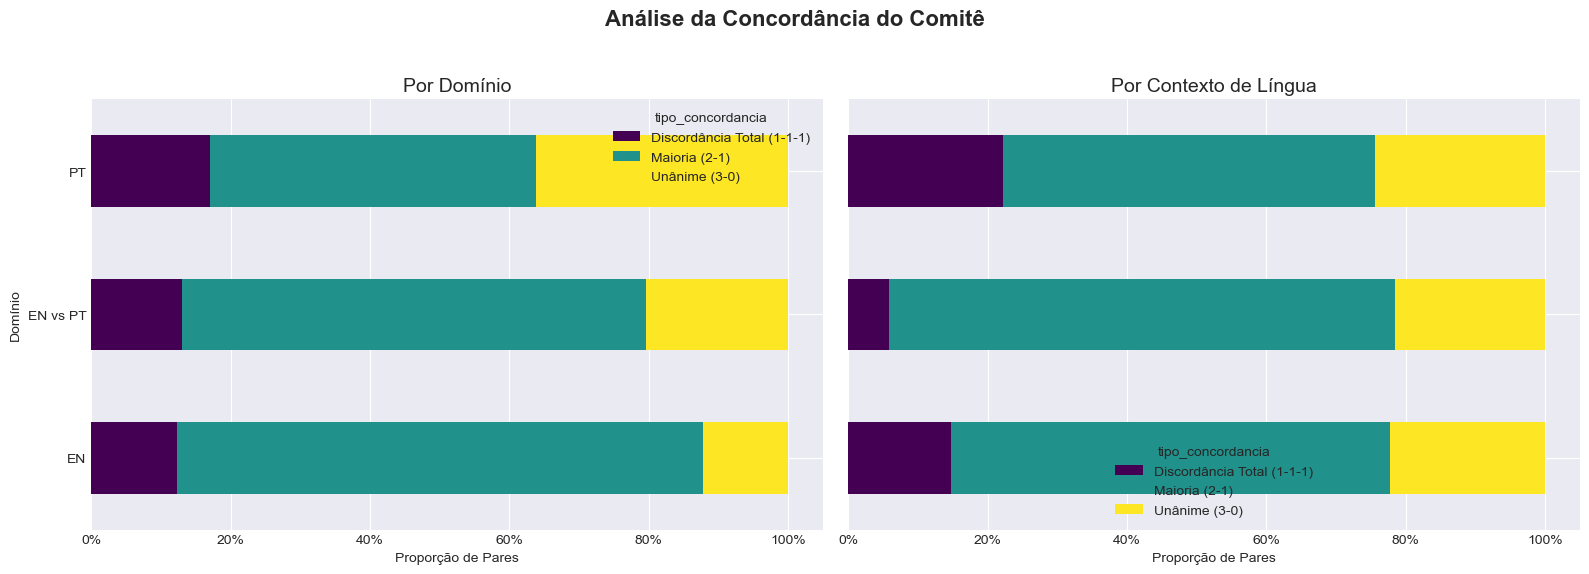

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Análise da Concordância do Comitê', fontsize=16, weight='bold')

consenso_por_dominio.plot(kind='barh', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Por Domínio', fontsize=14)
axes[0].set_xlabel('Proporção de Pares')
axes[0].set_ylabel('Domínio')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

consenso_por_lingua.plot(kind='barh', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Por Contexto de Língua', fontsize=14)
axes[1].set_xlabel('Proporção de Pares')
axes[1].set_ylabel('')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### VALIDAÇÃO DOS JUÍZES-LLM vs HUMANOS

In [23]:
# Acurácia pareada
print("\n--- Acurácia Pareada ---\n")
for judge in judges:
    coluna_juiz = f'{judge}_winner'
    if coluna_juiz in df_validacao.columns:
        accuracy = accuracy_score(df_validacao['human_winner'], df_validacao[coluna_juiz])
        
        # Calcular IC para acurácia
        n_corretos = (df_validacao['human_winner'] == df_validacao[coluna_juiz]).sum()
        _, ic_inf, ic_sup = proporcao_com_ic(n_corretos, len(df_validacao))
        
        print(f"{judge.title():15s}: {formatar_ic(accuracy, ic_inf, ic_sup)}")


--- Acurácia Pareada ---

Claude         : 48.00% (IC 95%: [40.16%, 55.94%])
Prometheus     : 33.33% (IC 95%: [26.29%, 41.21%])
Mistral        : 40.00% (IC 95%: [32.50%, 48.00%])


* **Acurácia Baixa** (Todos abaixo de 50%): Significa que os juízes-LLM, na maioria das vezes, não escolheram o mesmo vencedor que a maioria dos humanos. O Claude foi o melhor, mas ainda assim só concordou 48% das vezes.

    Isto valida a nossa descoberta anterior sobre o baixo Fleiss' Kappa humano. Se os próprios humanos tiveram dificuldade em concordar entre si, é perfeitamente natural que um LLM também não consiga "adivinhar" a preferência de um grupo dividido.

In [24]:
mapping = {'A': 1, 'B': -1, 'Tie': 0, 'Empate': 0}
df_validacao['human_choice_numeric'] = df_validacao['human_winner'].map(mapping)

tau_results = []
for judge in judges:
    coluna_juiz = f'{judge}_winner'
    if coluna_juiz in df_validacao.columns:
        judge_choice_numeric = df_validacao[coluna_juiz].map(mapping)
        tau, p_value = kendalltau(
            df_validacao['human_choice_numeric'], 
            judge_choice_numeric.fillna(0)
        )
        
        significancia = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"{judge.title():15s}: τ = {tau:+.4f} (p = {p_value:.4g}) {significancia}")
        
        tau_results.append({
            'Juiz': judge.title(),
            'Kendall_Tau': tau,
            'P_Value': p_value,
            'Significativo': p_value < 0.05
        })

print("\nLegenda: *** p<0.001, ** p<0.01, * p<0.05, ns não significativo")

Claude         : τ = +0.2171 (p = 0.003727) **
Prometheus     : τ = +0.1800 (p = 0.01664) *
Mistral        : τ = +0.0970 (p = 0.1995) ns

Legenda: *** p<0.001, ** p<0.01, * p<0.05, ns não significativo


**Kendall's Tau:**

* Claude e Prometheus mostram correlações positivas e estatisticamente significativas — ou seja, há concordância entre o julgamento e a variável comparada.
Isso indica que esses modelos podem ter viés.

* Mistral, por outro lado, apresenta uma correlação baixa e não significativa → não há evidência estatística de viés nesse caso.

### ANÁLISE DE ESTABILIDADE (VARIÂNCIA INTRA-PROMPT)

In [25]:
def calcular_instabilidade(df, agrupamento=['domain', 'language_context']):
    """
    Calcula desvio-padrão do win rate entre diferentes execuções (sample_n)
    Alto DP = comportamento instável/sensível a pequenas variações
    """
    resultados = []
    
    for grupo, dados in df.groupby(agrupamento):
        if dados['sample_n'].isna().all():
            continue
            
        # Para cada sample_n, calcula win rate de A
        win_rates = []
        for sample in sorted(dados['sample_n'].dropna().unique()):
            subset = dados[dados['sample_n'] == sample]
            if len(subset) > 0:
                wr = (subset['gold_winner'] == 'A').mean()
                win_rates.append(wr)
        
        if len(win_rates) >= 2:  # Precisa de pelo menos 2 execuções
            resultados.append({
                **dict(zip(agrupamento, grupo)),
                'win_rate_medio': np.mean(win_rates),
                'desvio_padrao': np.std(win_rates, ddof=1),
                'n_execucoes': len(win_rates),
                'min_wr': np.min(win_rates),
                'max_wr': np.max(win_rates),
                'amplitude': np.max(win_rates) - np.min(win_rates)
            })
    
    return pd.DataFrame(resultados).sort_values('desvio_padrao', ascending=False)

In [26]:
instabilidade = calcular_instabilidade(df_analise)

print("\n--- Índice de Instabilidade (Top 10 configurações mais instáveis) ---\n")
print(instabilidade.head(10).to_string(index=False))

print(f"\n--- Estatísticas Gerais de Estabilidade ---")
print(f"Desvio-padrão médio: {instabilidade['desvio_padrao'].mean():.4f}")
print(f"Amplitude média: {instabilidade['amplitude'].mean():.4f}")
print(f"Máxima instabilidade observada: {instabilidade['desvio_padrao'].max():.4f}")

print("\nInterpretação:")
print("- DP < 0.05: Alta estabilidade (decisões consistentes entre execuções)")
print("- DP 0.05-0.10: Estabilidade moderada")
print("- DP > 0.10: Instabilidade preocupante (sensibilidade ao contexto/aleatoriedade)")


--- Índice de Instabilidade (Top 10 configurações mais instáveis) ---

           domain language_context  win_rate_medio  desvio_padrao  n_execucoes   min_wr   max_wr  amplitude
        Technical               PT        0.621920       0.138795            5 0.428571 0.777778   0.349206
General Knowledge               EN        0.467509       0.117544            5 0.375000 0.666667   0.291667
         Creative         EN vs PT        0.533149       0.098766            5 0.444444 0.684211   0.239766
        Technical         EN vs PT        0.564633       0.098385            5 0.428571 0.700000   0.271429
         Creative               EN        0.504610       0.092894            5 0.378378 0.625000   0.246622
         Creative               PT        0.607603       0.081280            5 0.466667 0.676471   0.209804
        Technical               EN        0.718502       0.073160            5 0.620690 0.794118   0.173428
General Knowledge         EN vs PT        0.543064       0.07053

### ANÁLISE DE EMPATES

In [27]:
n_empates = (df_analise['gold_winner'] == 'Tie').sum()
prop_empate, ic_inf, ic_sup = proporcao_com_ic(n_empates, len(df_analise))

In [28]:
print("\n--- Taxa de Empate Global ---")
print(f"Empates: {formatar_ic(prop_empate, ic_inf, ic_sup)}")

# Por língua
print("\n--- Taxa de Empate por Contexto de Língua ---\n")
for lang in df_analise['language_context'].dropna().unique():
    subset = df_analise[df_analise['language_context'] == lang]
    n = (subset['gold_winner'] == 'Tie').sum()
    prop, ic_inf, ic_sup = proporcao_com_ic(n, len(subset))
    print(f"{lang:15s}: {formatar_ic(prop, ic_inf, ic_sup)}")

# Por domínio
print("\n--- Taxa de Empate por Domínio ---\n")
for domain in df_analise['domain'].dropna().unique():
    subset = df_analise[df_analise['domain'] == domain]
    n = (subset['gold_winner'] == 'Tie').sum()
    prop, ic_inf, ic_sup = proporcao_com_ic(n, len(subset))
    print(f"{domain:20s}: {formatar_ic(prop, ic_inf, ic_sup)}")


--- Taxa de Empate Global ---
Empates: 17.40% (IC 95%: [15.57%, 19.40%])

--- Taxa de Empate por Contexto de Língua ---

EN vs PT       : 18.20% (IC 95%: [15.06%, 21.82%])
EN             : 21.25% (IC 95%: [17.93%, 24.99%])
PT             : 12.53% (IC 95%: [9.88%, 15.76%])

--- Taxa de Empate por Domínio ---

Technical           : 7.34% (IC 95%: [5.32%, 10.03%])
General Knowledge   : 23.23% (IC 95%: [19.86%, 26.99%])
Creative            : 20.82% (IC 95%: [17.45%, 24.66%])


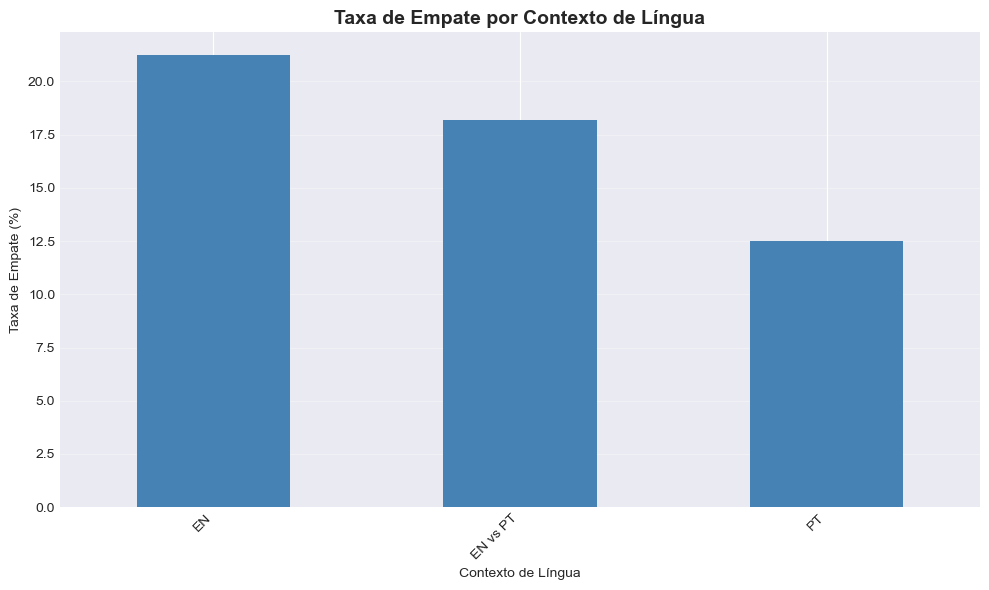

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
empates_por_lingua = df_analise.groupby('language_context')['gold_winner'].apply(
    lambda x: (x == 'Tie').mean() * 100
).sort_values(ascending=False)

empates_por_lingua.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Taxa de Empate por Contexto de Língua', fontsize=14, weight='bold')
ax.set_xlabel('Contexto de Língua')
ax.set_ylabel('Taxa de Empate (%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### ANÁLISE DE VIÉS DE LÍNGUA DE AVALIAÇÃO (DUPLO PIVÔ)

Para detectar viés de língua nos juízes-LLM, usamos metodologia de duplo pivô:

IMPORTANTE: O prompt do juiz é SEMPRE em inglês. O que muda são as RESPOSTAS.

1. PIVÔ-EN (Respostas avaliadas em inglês):
   - Response A: EN (english_original - gerada nativamente em EN)
   - Response B: EN (portuguese_pivoted - traduzida de PT→EN)
   - Juiz avalia: "Qual resposta EM INGLÊS é melhor?"

2. PIVÔ-PT (Respostas avaliadas em português):
   - Response A: PT (english_pivoted - traduzida de EN→PT)
   - Response B: PT (portuguese_original - gerada nativamente em PT)
   - Juiz avalia: "Qual resposta EM PORTUGUÊS é melhor?"

Rationale:
- Se EN nativa vence em AMBOS os pivôs → capacidade genuinamente superior
- Se cada língua vence no seu pivô → juízes são influenciados pela língua de leitura

In [30]:
df_master = pd.read_csv('../../data/processed/sample_master.csv')
df_pivot_en_full = pd.merge(
    df_analise[df_analise['language_context'] == 'EN vs PT'],
    df_master[['evaluation_id', 'source_of_A', 'source_of_B']],
    on='evaluation_id',
    how='left'
)

print(df_pivot_en_full.shape)
df_pivot_en_full.head(1)

(500, 19)


,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n,source_of_A,source_of_B
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.0,A,5.0,A,A,Technical,EN vs PT,1,english_original,portuguese_pivoted


In [31]:
df_pivot_pt_raw = pd.read_csv('../../data/processed/blind_pool_cross_lingual_pt.csv')
df_pivot_pt_judged = pd.read_csv('../../data/judged/committee_llm_consensus_lingual_pt.csv')

df_pivot_pt_full = pd.merge(
    df_pivot_pt_judged,
    df_pivot_pt_raw[['evaluation_id', 'source_of_A', 'source_of_B']],
    on='evaluation_id',
    how='left'
)

print(df_pivot_pt_full.shape)
df_pivot_pt_full.head(1)

(500, 15)


,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,source_of_A,source_of_B
0,CG011_llama-3.3-70b-versatile_2_General Knowle...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""T"",\n""general_justification"": ""T...","{\n ""winner"": ""A"",\n ""general_j...",A,4.5,A,4.75,Tie,5.0,A,english_pivoted_to_pt,portuguese_original


In [32]:
print("--- Verificação de Mapeamento de Sources ---\n")
print("Pivô-EN (avaliação em inglês):")
print(f"  source_of_A valores únicos: {df_pivot_en_full['source_of_A'].unique()}")
print(f"  source_of_B valores únicos: {df_pivot_en_full['source_of_B'].unique()}")
print()
print("Pivô-PT (avaliação em português):")
print(f"  source_of_A valores únicos: {df_pivot_pt_full['source_of_A'].unique()}")
print(f"  source_of_B valores únicos: {df_pivot_pt_full['source_of_B'].unique()}")

--- Verificação de Mapeamento de Sources ---

Pivô-EN (avaliação em inglês):
  source_of_A valores únicos: ['english_original' 'portuguese_pivoted']
  source_of_B valores únicos: ['portuguese_pivoted' 'english_original']

Pivô-PT (avaliação em português):
  source_of_A valores únicos: ['english_pivoted_to_pt' 'portuguese_original']
  source_of_B valores únicos: ['portuguese_original' 'english_pivoted_to_pt']


In [33]:
def identificar_natividade(row):
    """
    Retorna (winner_type, winner_language) onde:
      - winner_type é 'Native', 'Translated' ou 'Tie'
      - winner_language é 'EN', 'PT' ou None

    Espera as colunas: 'gold_winner', 'source_of_A', 'source_of_B'
    """
    winner = row.get('gold_winner')
    if pd.isna(winner) or winner == 'Tie':
        return 'Tie', None

    # garantia: winner deve ser 'A' ou 'B'
    if winner not in ('A', 'B'):
        return None, None

    source_col = f'source_of_{winner}'
    source = row.get(source_col)

    if pd.isna(source):
        return None, None

    s = str(source).lower()

    # detecta língua
    if 'english' in s:
        lang = 'EN'
    elif 'portuguese' in s or 'português' in s:
        lang = 'PT'
    else:
        lang = None

    # detecta se é original (nativa) ou pivot/translated
    if 'original' in s:
        winner_type = 'Native'
    elif 'pivot' in s or 'pivoted' in s or 'pivoted_to' in s or 'pivotedto' in s:
        winner_type = 'Translated'

    return winner_type, lang

In [34]:
df_pivot_en_full[['winner_type', 'winner_language']] = df_pivot_en_full.apply(
    lambda row: pd.Series(identificar_natividade(row)), axis=1
)
df_pivot_en_full.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,...,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n,source_of_A,source_of_B,winner_type,winner_language
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,...,5.00,A,A,Technical,EN vs PT,1,english_original,portuguese_pivoted,Native,EN
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,...,4.75,A,B,General Knowledge,EN vs PT,4,english_original,portuguese_pivoted,Native,EN


In [35]:
df_pivot_pt_full[['winner_type', 'winner_language']] = df_pivot_pt_full.apply(
    lambda row: pd.Series(identificar_natividade(row)), axis=1
)
df_pivot_pt_full.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,source_of_A,source_of_B,winner_type,winner_language
0,CG011_llama-3.3-70b-versatile_2_General Knowle...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""T"",\n""general_justification"": ""T...","{\n ""winner"": ""A"",\n ""general_j...",A,4.50,A,4.75,Tie,5.00,A,english_pivoted_to_pt,portuguese_original,Translated,EN
1,TC018_llama-3.3-70b-versatile_3_Technical_mini...,**Notação Big O: uma medida de complexidade**\...,A notação Big O é uma medida de complexidade d...,"{\n ""winner"": ""B"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_j...",B,4.75,A,5.00,Tie,4.75,Disagreement,english_pivoted_to_pt,portuguese_original,None,None


In [36]:
print("--- TAXA DE VITÓRIA DA RESPOSTA NATIVA ---\n")

results_summary = []

for df, label, pivo in [
    (df_pivot_en_full, 'Pivô-EN (avaliando em inglês)', 'EN'),
    (df_pivot_pt_full, 'Pivô-PT (avaliando em português)', 'PT')
]:
    n_total = len(df)
    n_native = (df['winner_type'] == 'Native').sum()
    n_translated = (df['winner_type'] == 'Translated').sum()
    n_tie = (df['winner_type'] == 'Tie').sum()
    
    prop_native, ic_inf, ic_sup = proporcao_com_ic(n_native, n_total)
    
    print(f"{label}:")
    print(f"  Native wins:     {formatar_ic(prop_native, ic_inf, ic_sup)}")
    print(f"  Translated wins: {n_translated/n_total:.1%}")
    print(f"  Tie:             {n_tie/n_total:.1%}")
    print()
    
    results_summary.append({
        'Pivot': pivo,
        'Label': label,
        'Native_Rate': prop_native,
        'IC_Inf': ic_inf,
        'IC_Sup': ic_sup,
        'N': n_total
    })

--- TAXA DE VITÓRIA DA RESPOSTA NATIVA ---

Pivô-EN (avaliando em inglês):
  Native wins:     57.40% (IC 95%: [53.03%, 61.66%])
  Translated wins: 8.6%
  Tie:             18.2%

Pivô-PT (avaliando em português):
  Native wins:     34.20% (IC 95%: [30.18%, 38.46%])
  Translated wins: 26.2%
  Tie:             19.0%



In [37]:
print("--- TAXA DE VITÓRIA POR LÍNGUA ---\n")

# Calcular taxas de vitória para cada língua nativa
en_wins_en_pivot = (
    (df_pivot_en_full['winner_type'] == 'Native') & 
    (df_pivot_en_full['winner_language'] == 'EN')
).sum() / len(df_pivot_en_full)

pt_wins_pt_pivot = (
    (df_pivot_pt_full['winner_type'] == 'Native') & 
    (df_pivot_pt_full['winner_language'] == 'PT')
).sum() / len(df_pivot_pt_full)

# ICs para essas taxas
en_n = ((df_pivot_en_full['winner_type'] == 'Native') & 
        (df_pivot_en_full['winner_language'] == 'EN')).sum()
en_prop, en_ic_inf, en_ic_sup = proporcao_com_ic(en_n, len(df_pivot_en_full))

pt_n = ((df_pivot_pt_full['winner_type'] == 'Native') & 
        (df_pivot_pt_full['winner_language'] == 'PT')).sum()
pt_prop, pt_ic_inf, pt_ic_sup = proporcao_com_ic(pt_n, len(df_pivot_pt_full))

print(f"EN (nativo) vence quando avaliado EM INGLÊS (Pivô-EN):")
print(f"{formatar_ic(en_prop, en_ic_inf, en_ic_sup)}")
print()
print(f"PT (nativo) vence quando avaliado EM PORTUGUÊS (Pivô-PT):")
print(f"{formatar_ic(pt_prop, pt_ic_inf, pt_ic_sup)}")
print()

--- TAXA DE VITÓRIA POR LÍNGUA ---

EN (nativo) vence quando avaliado EM INGLÊS (Pivô-EN):
57.40% (IC 95%: [53.03%, 61.66%])

PT (nativo) vence quando avaliado EM PORTUGUÊS (Pivô-PT):
34.20% (IC 95%: [30.18%, 38.46%])



In [38]:
asymmetry = abs(en_wins_en_pivot - pt_wins_pt_pivot)
print(f"Assimetria: {asymmetry:.1%}")

# Interpretação
if asymmetry > 0.15:
    print("Alta assimetria (>15pp): Uma língua tem vantagem desproporcional")
elif asymmetry > 0.10:
    print("Assimetria moderada (>10pp): Possível viés desequilibrado")
else:
    print("Baixa assimetria (<10pp): viés simétrico ou ausente")

Assimetria: 23.2%
Alta assimetria (>15pp): Uma língua tem vantagem desproporcional


In [39]:
both_high = en_wins_en_pivot > 0.55 and pt_wins_pt_pivot > 0.55
both_low = en_wins_en_pivot < 0.45 and pt_wins_pt_pivot < 0.45
en_dominant = en_wins_en_pivot > 0.55 and pt_wins_pt_pivot < 0.45
pt_compensates = en_wins_en_pivot < 0.45 and pt_wins_pt_pivot > 0.55

if both_high:
    pattern = "VANTAGEM BILATERAL"
    interpretation = "Cada idioma ganha mais quando avaliado em seu próprio idioma"
elif both_low:
    pattern = "NENHUMA VANTAGEM CLARA"
    interpretation = "Nenhuma das línguas vence consistentemente em sua mudança de direção"
elif en_dominant:
    pattern = "SUPERIORIDADE EM INGLÊS + BIAS"
    interpretation = "EN vence no seu pivô, mas PT não vence no seu"
elif pt_compensates:
    pattern = "COMPENSAÇÃO DE PORTUGUÊS"
    interpretation = "PT vence no seu pivô, mas EN não vence no seu"
else:
    pattern = "MISTO (requer análise mais profunda)"
    interpretation = "O padrão não se enquadra nas categorias padrão"

print(f"PADRÃO DETECTADO: {pattern}")
print(f"{interpretation}")

PADRÃO DETECTADO: SUPERIORIDADE EM INGLÊS + BIAS
EN vence no seu pivô, mas PT não vence no seu


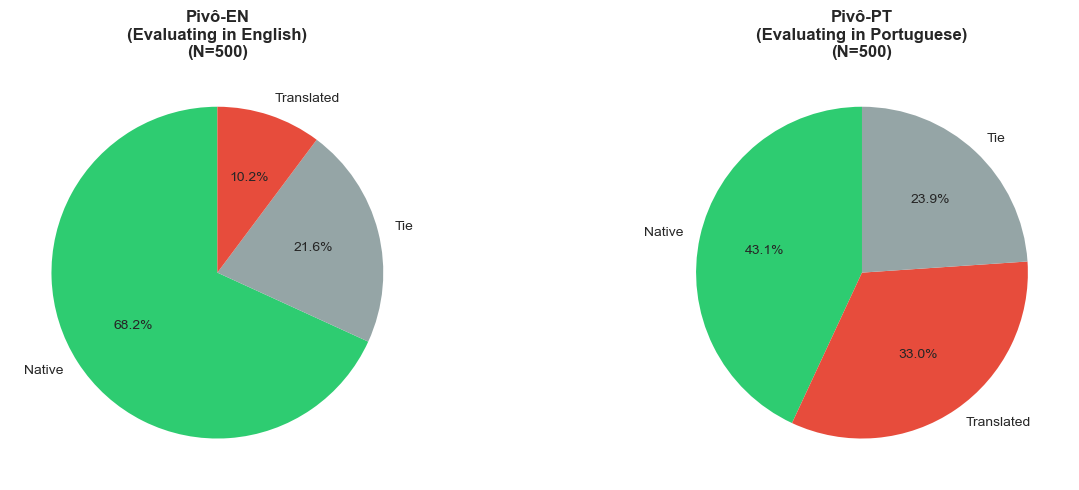

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'Native': '#2ecc71', 'Translated': '#e74c3c', 'Tie': '#95a5a6'}

for ax, (df, label) in zip(axes, [
    (df_pivot_en_full, 'Pivô-EN\n(Evaluating in English)'),
    (df_pivot_pt_full, 'Pivô-PT\n(Evaluating in Portuguese)')
]):
    counts = df['winner_type'].value_counts()
    ax.pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=[colors.get(x, '#bdc3c7') for x in counts.index]
    )
    ax.set_title(f'{label}\n(N={len(df)})', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

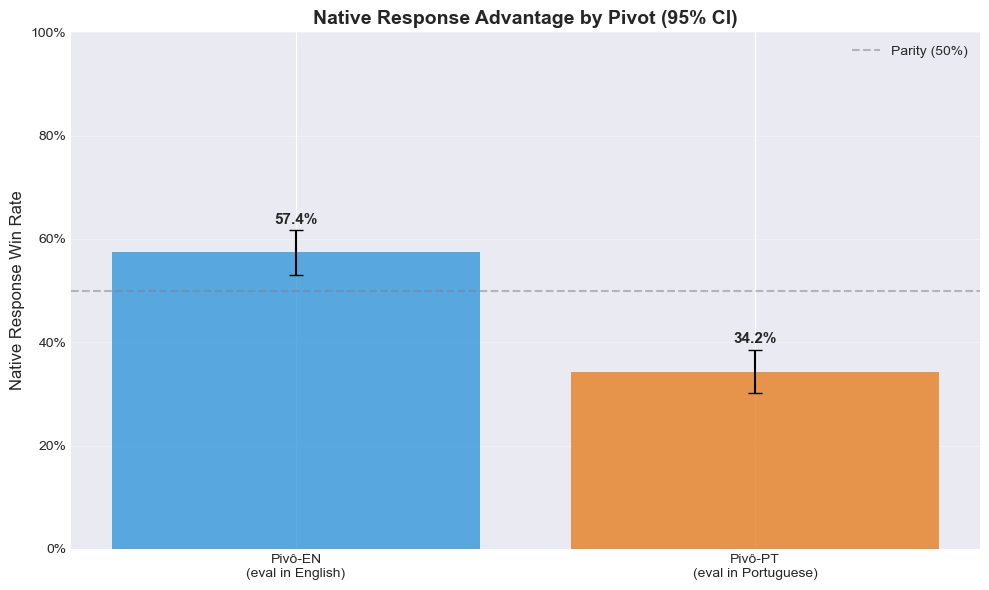

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

df_plot = pd.DataFrame(results_summary)
x = np.arange(len(df_plot))

bars = ax.bar(
    x, 
    df_plot['Native_Rate'], 
    yerr=[
        df_plot['Native_Rate'] - df_plot['IC_Inf'], 
        df_plot['IC_Sup'] - df_plot['Native_Rate']
    ],
    capsize=5, 
    color=['#3498db', '#e67e22'],
    alpha=0.8
)

ax.set_ylabel('Native Response Win Rate', fontsize=12)
ax.set_title('Native Response Advantage by Pivot (95% CI)', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Pivô-EN\n(eval in English)', 'Pivô-PT\n(eval in Portuguese)'])
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Parity (50%)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Adicionar valores
for bar, row in zip(bars, df_plot.itertuples()):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + 0.05,
        f'{row.Native_Rate:.1%}',
        ha='center', 
        va='bottom',
        fontsize=11,
        weight='bold'
    )

plt.tight_layout()
plt.show()

### PREPARAÇÃO DOS DADOS FINAIS

In [42]:
df_analise.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A,A,Technical,EN vs PT,1
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A,B,General Knowledge,EN vs PT,4


In [43]:
df_analise.to_csv('../../data/analysis/complete_analysis.csv', index=False, encoding='utf-8-sig')

In [44]:
df_pivot_pt_full.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,source_of_A,source_of_B,winner_type,winner_language
0,CG011_llama-3.3-70b-versatile_2_General Knowle...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,**O que é DNA?**\n\nO DNA (ácido desoxirribonu...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""T"",\n""general_justification"": ""T...","{\n ""winner"": ""A"",\n ""general_j...",A,4.50,A,4.75,Tie,5.00,A,english_pivoted_to_pt,portuguese_original,Translated,EN
1,TC018_llama-3.3-70b-versatile_3_Technical_mini...,**Notação Big O: uma medida de complexidade**\...,A notação Big O é uma medida de complexidade d...,"{\n ""winner"": ""B"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_j...",B,4.75,A,5.00,Tie,4.75,Disagreement,english_pivoted_to_pt,portuguese_original,None,None


In [45]:
df_pivot_en_full.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,...,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n,source_of_A,source_of_B,winner_type,winner_language
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,...,5.00,A,A,Technical,EN vs PT,1,english_original,portuguese_pivoted,Native,EN
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,...,4.75,A,B,General Knowledge,EN vs PT,4,english_original,portuguese_pivoted,Native,EN


In [46]:
df_pivot_en_full.to_csv('../../data/analysis/pivot_en_recoded.csv', index=False, encoding='utf-8-sig')
df_pivot_pt_full.to_csv('../../data/analysis/pivot_pt_recoded.csv', index=False, encoding='utf-8-sig')